In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
def transform_target_log3(data, target_name):
    val = data[target_name].values 
    return np.array([0 if v == 0 else np.log(v) / np.log(3) for v in val])


def read_x_y(path, target_name, version):
    data = pd.read_csv(path)
    data[target_name] = transform_target_log3(data, target_name)
    X = data.drop(columns = target_name)
    y = data[target_name]
    return X, y


def get_categorical_features(data):
    num_unique = data.nunique()
    categorical_features = num_unique[num_unique <= 10].index.tolist()
    # Remove variables from categorical features list that can be treated as continuous
    for col in ["POVCAT15", "RTHLTH31", "MNHLTH31"]:
        categorical_features.remove(col)
    return categorical_features


def one_hot_scikit(X):
    categorical_features = get_categorical_features(X)
    encoder = OneHotEncoder(sparse = False, handle_unknown = "ignore")
    X_encoded = pd.DataFrame(encoder.fit_transform(X[categorical_features]))
    X_encoded.columns = encoder.get_feature_names(categorical_features)
    X.drop(categorical_features, axis = 1, inplace = True)
    X = pd.concat([X, X_encoded], axis = 1)
    return X


def one_hot(data):
    categorical_features = get_categorical_features(data)
    for col in categorical_features:
        df_cat_vars_one_hot = pd.get_dummies(data[col], prefix = col)
        data = data.drop(columns = [col])
        data = pd.concat([data, df_cat_vars_one_hot], axis = 1)
    return data


def print_model_results(y_train, y_pred_train, y_test, y_pred_test):
    mse_train = mean_squared_error(y_train, y_pred_train)
    rmse_train = np.sqrt(mse_train)
    
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    
    print("Training: \nRMSE: ", rmse_train, " | MAE: ", mean_absolute_error(y_train, y_pred_train), " | R^2: ", r2_score(y_train, y_pred_train), "\n")
    print("Test: \nRMSE: ", rmse_test, " | MAE: ", mean_absolute_error(y_test, y_pred_test), " | R^2: ", r2_score(y_test, y_pred_test), "\n")
    

def plot_target_pred(target_name, target, pred_name, pred, path):
    plt.figure(figsize = (10, 8))
    plt.scatter(target, pred, s = 90, alpha = 0.7)
    plt.plot(target, target, c = "y", lw = 5)
    plt.xlabel(target_name, size = 14)
    plt.ylabel(pred_name, size = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.savefig(path + target_name[2:] + ".svg")
    plt.show()

---

### Building models

In [3]:
path = ".\..\dane\MEPS_data_preprocessed"
X_train, y_train = read_x_y(path + "_train.csv", "HEALTHEXP")
X_test, y_test = read_x_y(path + "_test.csv", "HEALTHEXP")

In [4]:
X_train = one_hot_scikit(X_train)
X_test = one_hot_scikit(X_test)

In [5]:
parameters = {
    "n_estimators": list(range(60, 71, 5)) + list(range(71, 81)) + list(range(85, 106, 5)),
    "max_depth": list(range(2, 8)),
    "min_samples_split": list(range(2, 8)),
    "min_samples_leaf": list(range(2, 8)),
    "random_state": [123]
}

In [6]:
xgb = GradientBoostingRegressor()
reg = GridSearchCV(xgb, parameters, n_jobs = -1)

In [7]:
%%time
reg.fit(X_train, y_train)

C:\Users\aga71\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Wall time: 7h 51min 11s


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n...
                             

In [8]:
reg.score(X_test, y_test)

0.3728014143837811

In [9]:
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
print_model_results(y_train, y_pred_train, y_test, y_pred_test)

Training: 
RMSE:  2.0396133775061136  | MAE:  1.5089425596799377  | R^2:  0.45441720670280983 

Test: 
RMSE:  2.1726508328005  | MAE:  1.6063298416672311  | R^2:  0.3728014143837811 



In [10]:
reg.best_params_

{'max_depth': 5,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 76,
 'random_state': 123}

In [11]:
pickle.dump(reg, open("xgb_gs_model_log3_v3.pickle", "wb"))

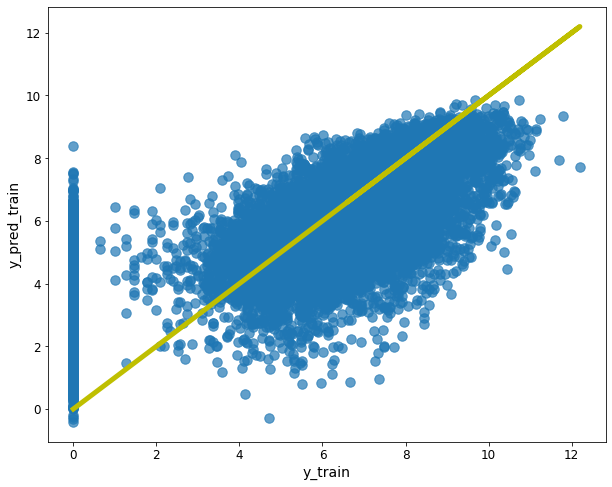

In [16]:
plot_target_pred("y_train", y_train, "y_pred_train", y_pred_train, "06-xgb_")

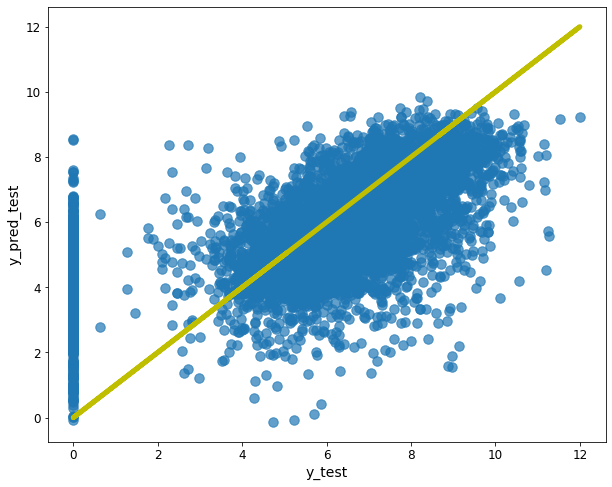

In [17]:
plot_target_pred("y_test", y_test, "y_pred_test", y_pred_test, "06-xgb_")

---

### Final version

In [12]:
path = ".\..\dane\MEPS_data_preprocessed_train.csv"
X, y = read_x_y(path, "HEALTHEXP", 2)

In [13]:
categorical_features = get_categorical_features(X)

categorical_transformer = Pipeline(
    steps = [
        ("onehot", OneHotEncoder(handle_unknown = "ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers = [
        ("cat", categorical_transformer, categorical_features)
    ]
)

regressor = GradientBoostingRegressor(n_estimators = 76, 
                                    max_depth = 5,
                                    min_samples_split = 2,
                                    min_samples_leaf = 5,
                                    random_state = 123)

reg_xgb = Pipeline(steps = [("preprocessor", preprocessor),
                      ("regressor", regressor)])

In [14]:
reg_xgb.fit(X, y)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('onehot',
                                                                   OneHotEncoder(categorical_features=None,
                                                                                 categories=None,
                                                                                 drop=None,
                                                                                 dtype=<class 'numpy.float64'>,
                                                                                 handle_unknown='ignore',
                                       

In [15]:
pickle.dump(reg_xgb, open("MEPS_xgb_model_final.pickle", "wb"))